In [2]:
import pickle
import os
import numpy as np
import csv
import argparse
import ast
import matplotlib.pyplot as plt
import pandas as pd
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"


In [3]:
def make_index_dict(label_csv):
    index_lookup = {}
    with open(label_csv, 'r') as f:
        csv_reader = csv.DictReader(f)
        line_count = 0
        for row in csv_reader:
            index_lookup[row['index']] = row['display_name'] #addtional col mid
            line_count += 1
    return index_lookup

In [4]:
label_csv = '../egs/audioset/data/class_labels_indices.csv'

In [5]:
class_dic = make_index_dict(label_csv)

In [6]:
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument("--model", type=str, default='ast', help="the model used")
parser.add_argument("--dataset", type=str, default="audioset", help="the dataset used", choices=["audioset","audioset_s", "esc50", "speechcommands"])
parser.add_argument("--n_mels", type=int, default=128, help="number of mel bins")
parser.add_argument("--dataset-portion", type=str, default='full', help="balance set or full set")
parser.add_argument('--mean', default=-12.7508, type=float, help='normalizing mean')
parser.add_argument('--std', default=11.7584, type=float, help='normalizing std')

parser.add_argument("--exp-dir", type=str, default="", help="directory to dump experiments")
parser.add_argument('--lr', '--learning-rate', default="0.001", type=str, metavar='LR', help='initial learning rate')
parser.add_argument("--optim", type=str, default="adam", help="training optimizer", choices=["sgd", "adam"])
parser.add_argument('-b', '--batch-size', default=12, type=int, metavar='N', help='mini-batch size')
parser.add_argument('-w', '--num-workers', default=32, type=int, metavar='NW', help='# of workers for dataloading (default: 32)')
parser.add_argument("--n-epochs", type=int, default=1, help="number of maximum training epochs")
# not used in the formal experiments
parser.add_argument("--lr_patience", type=int, default=2, help="how many epoch to wait to reduce lr if mAP doesn't improve")

parser.add_argument("--n-print-steps", type=int, default=100, help="number of steps to print statistics")

parser.add_argument('--freqm', help='frequency mask max length', type=int, default=0)
parser.add_argument('--timem', help='time mask max length', type=int, default=0)
parser.add_argument("--mixup", type=float, default=0, help="how many (0-1) samples need to be mixup during training")
parser.add_argument("--bal", type=str, default=None, help="use balanced sampling or not")
# the stride used in patch spliting, e.g., for patch size 16*16, a stride of 16 means no overlapping, a stride of 10 means overlap of 6.
parser.add_argument("--fstride", type=int, default=10, help="soft split freq stride, overlap=patch_size-stride")
parser.add_argument("--tstride", type=int, default=10, help="soft split time stride, overlap=patch_size-stride")
parser.add_argument('--imagenet_pretrain', help='if use ImageNet pretrained audio spectrogram transformer model', type=ast.literal_eval, default='True')
parser.add_argument('--audioset_pretrain', help='if use ImageNet and audioset pretrained audio spectrogram transformer model', type=ast.literal_eval, default='False')
parser.add_argument('--suffix', type=str, default='')

args = parser.parse_args(args=['--model=ast','--fstride=8', '--tstride=8','--dataset=audioset_s','--batch-size=80', '--lr=1e-5', '--freqm=12', '--timem=75','--mixup=0.5','--mean=-27.248297','--std=37.681698','--n-epochs=10','--suffix=ast_challenge-40.95'])

In [7]:
exp_id = f"../egs/audioset/exp/{args.dataset}-{args.dataset_portion}-f{args.fstride}-t{args.tstride}-p{args.imagenet_pretrain}-b{args.batch_size}-lr{args.lr}-{args.suffix}"
print(exp_id)

../egs/audioset/exp/audioset_s-full-f8-t8-pTrue-b80-lr1e-5-ast_challenge-40.95


In [8]:
exp_id = f"../egs/audioset/exp/{args.dataset}-{args.dataset_portion}-f{args.fstride}-t{args.tstride}-p{args.imagenet_pretrain}-b{args.batch_size}-lr{args.lr}-fm{args.freqm}-tm{args.timem}-mix{args.mixup}-m{args.mean}-std{args.std}-epoch{args.n_epochs}-{args.suffix}"
print(exp_id)

../egs/audioset/exp/audioset_s-full-f8-t8-pTrue-b80-lr1e-5-fm12-tm75-mix0.5-m-27.248297-std37.681698-epoch10-ast_challenge-40.95


In [88]:
exp_id_best='../egs/audioset/exp/test-full-f10-t10-pTrue-b12-lr1e-5'
print(exp_id_best)

../egs/audioset/exp/test-full-f10-t10-pTrue-b12-lr1e-5


In [10]:
exp_id='../egs/audioset/exp/TALtrans-audioset_s-full-pTrue-b448-lr4e-4-fm12-tm60-mix0.3-m-29.686901-std40.898224-epoch10-conv10-pool5-trans2-new_model_dev_41.1'
print(exp_id)

../egs/audioset/exp/TALtrans-audioset_s-full-pTrue-b448-lr4e-4-fm12-tm60-mix0.3-m-29.686901-std40.898224-epoch10-conv10-pool5-trans2-new_model_dev_41.1


In [11]:
exp_id_2nd='../egs/audioset/exp/TALtrans-audioset-full-pTrue-b400-lr4e-4-fm36-tm192-mix0.3-m-3.6788461-std4.3739743-epoch10-conv10-pool5-trans2-big_feat_embed-43.7'
print(exp_id_2nd)

../egs/audioset/exp/TALtrans-audioset-full-pTrue-b400-lr4e-4-fm36-tm192-mix0.3-m-3.6788461-std4.3739743-epoch10-conv10-pool5-trans2-big_feat_embed-43.7


In [12]:
exp_id='../egs/audioset/exp/TAL-audioset-full-pTrue-b100-lr4e-4-fm36-tm192-mix0.3-m-3.6788461-std4.3739743-epoch10-conv10-pool5-trans2-big_feat_embed-42.9'
print(exp_id)

../egs/audioset/exp/TAL-audioset-full-pTrue-b100-lr4e-4-fm36-tm192-mix0.3-m-3.6788461-std4.3739743-epoch10-conv10-pool5-trans2-big_feat_embed-42.9


In [13]:
exp_id='../egs/audioset/exp/TAL-audioset_s-full-pTrue-b400-lr1.6e-3-fm12-tm75-mix0.3-m-29.072655-std40.71728-epoch10-conv10-pool5-trans2-big_feat_embed1024/'
print(exp_id)

../egs/audioset/exp/TAL-audioset_s-full-pTrue-b400-lr1.6e-3-fm12-tm75-mix0.3-m-29.072655-std40.71728-epoch10-conv10-pool5-trans2-big_feat_embed1024/


In [37]:
exp_id_4='../egs/audioset/exp/audioset-full-f10-t10-pTrue-b20-lr1e-5-fm36-tm192-mix0.3-m-3.6788461-std4.3739743-epoch10-ast_challenge-43.0'

In [15]:
exp_id='../egs/audioset/exp/resnet-audioset-full-pTrue-b188-lr1.6e-4-fm48-tm192-mix0.5-m-3.3458831-std4.1563106-epoch10-resnet_pretrain-fix-prev-bug-41.04'

In [64]:
exp_id_res='../egs/audioset/exp/resnet-audioset-full-pFalse-b128-lr1e-4-fm48-tm192-mix0.5-m-3.3458831-std4.1563106-epoch10-resnet_no-pretrain-39.93'

In [17]:
exp_id='../egs/audioset/exp/resnet-audioset_s-full-pTrue-b188-lr1.6e-4-fm12-tm75-mix0.3-m-29.072655-std40.71728-epoch10-resnet_pretrain-small-feat2-38.2'

In [129]:
exp_id_res2='../egs/audioset/exp/resnet-audioset_s-full-pFalse-b512-lr4.8e-4-fm12-tm75-mix0.3-m-29.072655-std40.71728-epoch10-resnet_no-pretrain-small-feat-37.0'

In [19]:
exp_id_1='../egs/audioset/exp/TALtrans-audioset_s-balanced-pTrue-b448-lr1e-3-fm0-tm0-mix0-m-29.686901-std40.898224-epoch60-conv10-pool5-trans2-baseline_rerun_full'

In [36]:
exp_id_8='../egs/audioset/exp/TALtrans-audioset_s-40k-pTrue-b448-lr1e-3-fm0-tm0-mix0-m-29.686901-std40.898224-epoch60-conv10-pool5-trans2-40k'

In [21]:
exp_id_5 = '../egs/audioset/exp/TALtrans-audioset_s-100k-pTrue-b448-lr1e-3-fm0-tm0-mix0-m-29.686901-std40.898224-epoch60-conv10-pool5-trans2-100k'

In [22]:
exp_id_base = '../egs/audioset/exp/audioset-balanced-f10-t10-pTrue-b24-lr5e-5-demo-33.1'#20

In [23]:
exp_id_2 = '../egs/audioset/exp/TALtrans-audioset_s-40k-pTrue-b448-lr1e-3-fm12-tm60-mix0.5-m-29.686901-std40.898224-epoch60-conv10-pool5-trans2-40k'


In [118]:
exp_id_6 ='../egs/audioset/exp/ast-audioset_s-balanced-f8-t8-pTrue-b128-lr2.5e-4-fm12-tm60-mix0.5-m-27.248297-std37.681698-epoch60-ast_unbalanced_sample'


In [25]:
exp_id_7 = '../egs/audioset/exp/TALtrans-audioset_s-60kc-pTrue-b448-lr1e-3-fm0-tm0-mix0-m-29.686901-std40.898224-epoch60-conv10-pool5-trans2-60kc-5/'

In [26]:
with open(os.path.join(exp_id_base, 'stats_21.pickle'), 'rb') as f:
    data = pickle.load(f, encoding='bytes')

In [133]:
with open(os.path.join(exp_id_res2, 'stats_7.pickle'), 'rb') as f:
    data2 = pickle.load(f, encoding='bytes')

In [144]:
with open(os.path.join(exp_id_best, 'stats_4.pickle'), 'rb') as f:
    data3 = pickle.load(f, encoding='bytes')

In [29]:
print(data2[0])

{'precisions': array([0.26157916, 0.26938432, 0.27328676, 0.27813326, 0.28319302,
       0.2886982 , 0.29424763, 0.30079054, 0.30625987, 0.31344637,
       0.32056653, 0.32975069, 0.33802817, 0.34225894, 0.34734918,
       0.35672981, 0.36696562, 0.37487504, 0.37337337, 0.37374749]), 'recalls': array([1.        , 0.97843923, 0.94046938, 0.90402595, 0.8664377 ,
       0.82808624, 0.78763595, 0.74775806, 0.70291929, 0.65960695,
       0.61324175, 0.56783057, 0.5174585 , 0.45850029, 0.39877886,
       0.34134707, 0.28105323, 0.21465369, 0.14233925, 0.07116962]), 'AP': 0.32967679158838376, 'fpr': array([0.        , 0.08997447, 0.18438382, 0.29565919, 0.40962236,
       0.55053084, 0.70239215, 0.86809569]), 'fnr': array([1.        , 0.848693  , 0.69948483, 0.56038924, 0.42930738,
       0.30452204, 0.18393436, 0.06659035]), 'auc': 0.6051039147084457, 'acc': 0.30099885702927}


In [30]:
print(len(data))

527


In [42]:
def format_eval_result(data):
    final_mAP = 0
    result_AP = []
    result_auc = []
    result_recall=[]
    for item in data:
        result_AP.append(item['AP'])
        result_auc.append(item['auc'])
        result_recall.append(np.mean(item['recalls']))
    final_mAP = np.mean(result_AP)
    final_auc = np.mean(result_auc)
    final_recall = np.mean(result_recall)
    return result_AP, result_auc, result_recall, final_mAP, final_auc, final_recall

In [32]:
result_AP, result_auc, result_recall, final_mAP, final_auc, final_recall = format_eval_result(data)
print(final_mAP, final_auc, final_recall)

0.33153434145483734 0.9559601942471534 0.820052249362378


In [134]:
result_AP2, result_auc2, result_recall2,  final_mAP2, final_auc2, final_recall2 = format_eval_result(data2)
print(final_mAP2, final_auc2, final_recall2)

0.3700205191398248 0.9607079186901575 0.9189157462533566


In [145]:
result_AP3,result_auc3, result_recall3,   final_mAP3, final_auc3, final_recall3 = format_eval_result(data3)
print(final_mAP3, final_auc3, final_recall3)

0.44904793083528133 0.9749593344127755 0.8837316427022623


# Analyze what are the worst performing classes

In [44]:
class_perfs = []
for class_id, mAP in enumerate(zip(result_AP, result_auc)):
    print(class_id, mAP[0], mAP[1])
    class_perfs.append((mAP[0], class_id))

0 0.7538603502490117 0.9206415534059053
1 0.032109358674480386 0.8291383785152479
2 0.06537424797015055 0.8942299317549021
3 0.2822159573309563 0.9352303421458684
4 0.2235038835890424 0.9626439216468126
5 0.28889299523958717 0.9606202960673877
6 0.2607442880790375 0.9886936422145269
7 0.31661960484174756 0.9539903470733855
8 0.13797706880708097 0.9248468460249236
9 0.11445821726081146 0.9212013083556349
10 0.07463794071291549 0.9272113675256277
11 0.12738501803029478 0.937087987385117
12 0.7877250992972884 0.9986629616707372
13 0.3579061314788422 0.9818953629400722
14 0.1707258919316306 0.9641847976191839
15 0.766248234096275 0.9975727257670557
16 0.3636287969980576 0.9722773753324266
17 0.474973677098888 0.9829414062308482
18 0.15517855105075506 0.9703030809882951
19 0.1262485794486316 0.9334326039641794
20 0.365856089450872 0.989920590431956
21 0.1148390520405041 0.9567246506836797
22 0.22147059372179936 0.9717460831713436
23 0.3065209642511195 0.9797647527910686
24 0.086029130465998

In [147]:
best_model_suck_50 = model_suck_50
print(best_model_suck_50)

[447, 434, 475, 130, 504, 1, 510, 280, 299, 502, 513, 507, 235, 466, 135, 508, 273, 444, 488, 2, 473, 509, 520, 486, 237, 38, 500, 277, 485, 349, 487, 266, 327, 5, 306, 279, 348, 505, 269, 275, 270, 124, 450, 523, 25, 51, 489, 226, 9, 260, 440, 297, 10, 113, 524, 33, 519, 518, 506, 354, 284, 233, 452, 407, 8, 80, 276, 158, 456, 216, 252, 227, 232, 219, 41, 265, 405, 503, 264, 442, 478, 356, 46, 258, 251, 239, 159, 388, 526, 477, 410, 21, 200, 44, 221, 18, 338, 448, 357, 497]


In [149]:
bal_model_suck_50 = model_suck_50
print(bal_model_suck_50)

[130, 434, 504, 513, 508, 1, 447, 299, 475, 135, 277, 486, 235, 510, 450, 500, 507, 502, 297, 280, 38, 298, 444, 341, 505, 357, 124, 239, 273, 349, 520, 466, 41, 2, 32, 33, 51, 358, 10, 260, 270, 482, 524, 519, 509, 348, 473, 24, 25, 227, 269, 460, 159, 216, 266, 275, 487, 360, 306, 452, 321, 234, 279, 237, 489, 523, 80, 354, 442, 125, 232, 46, 488, 327, 356, 485, 471, 284, 440, 226, 378, 9, 158, 21, 251, 252, 176, 264, 88, 229, 19, 456, 11, 407, 326, 426, 441, 448, 248, 305]


In [151]:
set1 = set(best_model_suck_50)
set2 = set(bal_model_suck_50)

# Find the intersection of the two sets (i.e., the overlap)
overlap = set1 & set2

# Print the number of overlaps
print(f"There are {len(overlap)} overlaps.")
print(overlap)

There are 77 overlaps.
{513, 2, 1, 519, 520, 9, 10, 523, 524, 21, 25, 33, 38, 41, 46, 51, 80, 124, 130, 135, 158, 159, 216, 226, 227, 232, 235, 237, 239, 251, 252, 260, 264, 266, 269, 270, 273, 275, 277, 279, 280, 284, 297, 299, 306, 327, 348, 349, 354, 356, 357, 407, 434, 440, 442, 444, 447, 448, 450, 452, 456, 466, 473, 475, 485, 486, 487, 488, 489, 500, 502, 504, 505, 507, 508, 509, 510}


In [157]:
worst_classes = []
for mAP, class_id in sorted(class_perfs3)[:100]:
    if class_id in overlap:
        print(f"Class ID: {class_id}, Class Name: {class_dic[str(class_id)]}, mAP: {mAP}")
        worst_classes.append((class_id, mAP))

Class ID: 447, Class Name: Squish, mAP: 0.032020366816031424
Class ID: 434, Class Name: Burst, pop, mAP: 0.04393282554945975
Class ID: 475, Class Name: Scrape, mAP: 0.04550273658922213
Class ID: 130, Class Name: Buzz, mAP: 0.048804866142920594
Class ID: 504, Class Name: Sound effect, mAP: 0.05297748245856823
Class ID: 1, Class Name: Male speech, man speaking, mAP: 0.05447139944016079
Class ID: 510, Class Name: Outside, rural or natural, mAP: 0.05801647402905368
Class ID: 280, Class Name: Exciting music, mAP: 0.058673988985959415
Class ID: 299, Class Name: Crackle, mAP: 0.05990179736734243
Class ID: 502, Class Name: Harmonic, mAP: 0.06296478637308855
Class ID: 513, Class Name: Noise, mAP: 0.06847530908026928
Class ID: 507, Class Name: Inside, large room or hall, mAP: 0.07426692725781371
Class ID: 235, Class Name: Jazz, mAP: 0.07811986879937083
Class ID: 466, Class Name: Bang, mAP: 0.07825235779957954
Class ID: 135, Class Name: Rattle, mAP: 0.07874374768187406
Class ID: 508, Class Name: 

In [158]:
print(worst_classes)

[(447, 0.032020366816031424), (434, 0.04393282554945975), (475, 0.04550273658922213), (130, 0.048804866142920594), (504, 0.05297748245856823), (1, 0.05447139944016079), (510, 0.05801647402905368), (280, 0.058673988985959415), (299, 0.05990179736734243), (502, 0.06296478637308855), (513, 0.06847530908026928), (507, 0.07426692725781371), (235, 0.07811986879937083), (466, 0.07825235779957954), (135, 0.07874374768187406), (508, 0.08481400066654737), (273, 0.08611261786676296), (444, 0.0862739837881234), (488, 0.08765218504187983), (2, 0.09081342934972128), (473, 0.09094397588845747), (509, 0.09237643957835626), (520, 0.0957223037258366), (486, 0.09593519378894282), (237, 0.09694893843055778), (38, 0.10082620727573469), (500, 0.10299317201420778), (277, 0.10506605376010385), (485, 0.10770913035454488), (349, 0.10872018154332613), (487, 0.11056828704101232), (266, 0.11201087092160178), (327, 0.11372978623230551), (306, 0.11612829218894417), (279, 0.11721919142616975), (348, 0.122342640226012

In [152]:
model_suck_50 = []
for mAP, class_id in sorted(class_perfs3)[:100]:
    print(class_id, class_dic[str(class_id)], mAP)
    model_suck_50.append(class_id)

447 Squish 0.032020366816031424
434 Burst, pop 0.04393282554945975
475 Scrape 0.04550273658922213
130 Buzz 0.048804866142920594
504 Sound effect 0.05297748245856823
1 Male speech, man speaking 0.05447139944016079
510 Outside, rural or natural 0.05801647402905368
280 Exciting music 0.058673988985959415
299 Crackle 0.05990179736734243
502 Harmonic 0.06296478637308855
513 Noise 0.06847530908026928
507 Inside, large room or hall 0.07426692725781371
235 Jazz 0.07811986879937083
466 Bang 0.07825235779957954
135 Rattle 0.07874374768187406
508 Inside, public space 0.08481400066654737
273 Christmas music 0.08611261786676296
444 Liquid 0.0862739837881234
488 Whir 0.08765218504187983
2 Female speech, woman speaking 0.09081342934972128
473 Flap 0.09094397588845747
509 Outside, urban or manmade 0.09237643957835626
520 White noise 0.0957223037258366
486 Creak 0.09593519378894282
237 Classical music 0.09694893843055778
38 Groan 0.10082620727573469
500 Silence 0.10299317201420778
277 Funny music 0.105

In [135]:
class_perfs2 = []
for class_id, mAP in enumerate(zip(result_AP2, result_auc2)):
    print(class_id, mAP[0], mAP[1])
    class_perfs2.append((mAP[0], class_id))

0 0.7526012372557593 0.918602995603832
1 0.07452148573648336 0.8132966180822612
2 0.1425375956074255 0.937242043925231
3 0.38659189881756695 0.9619901461451708
4 0.2680307980487494 0.9750062303743209
5 0.07073990445119656 0.9527006595889613
6 0.42999915052763243 0.9956391726887616
7 0.42610421930993153 0.9832768446061573
8 0.16018302755174196 0.945813228178304
9 0.07182796828252483 0.9395485294515179
10 0.17884543970561034 0.9629541942879929
11 0.1995561219573833 0.9769655582370488
12 0.8649949605987819 0.9992257721510575
13 0.5073752731091032 0.996223562444965
14 0.26313020965733996 0.969973410296932
15 0.7786585595360103 0.9982279852900267
16 0.38548357034220504 0.9764466057569505
17 0.6082317740222616 0.9910245452212894
18 0.17002913775799022 0.9797934744411104
19 0.25233851918591393 0.9719483626576284
20 0.38203941164460364 0.9874070708671969
21 0.19273079305899468 0.9721776404326372
22 0.4046654607790776 0.981411055176195
23 0.506842659898735 0.9817169802395048
24 0.26069415479938

In [114]:
class_perfs3 = []
for class_id, mAP in enumerate(zip(result_AP3, result_auc3)):
    print(class_id, mAP[0], mAP[1])
    class_perfs3.append((mAP[0], class_id))

0 0.8132202899522344 0.9406412976786993
1 0.05447139944016079 0.8449694989106754
2 0.09081342934972128 0.9410899291976036
3 0.42075833349262404 0.9721412560947396
4 0.3210966975440649 0.9745487405061872
5 0.11393374581465152 0.9577380233394569
6 0.425728731905953 0.9955035030848061
7 0.46427930738718143 0.9822791498323413
8 0.17256891124915363 0.9551626785028565
9 0.1479993336498161 0.9453543502207973
10 0.15664345751863276 0.9694009700118132
11 0.2512413227487011 0.9873511934675893
12 0.8672350243692006 0.9993298474945533
13 0.5308378017701505 0.995079021014964
14 0.3064615903156733 0.9864582046286176
15 0.8439427069401371 0.9985518946367831
16 0.44182817144446423 0.9788603560755293
17 0.5893576783676119 0.9909885466113078
18 0.22115286851792193 0.9841047752170052
19 0.32013699648851063 0.9841873216080772
20 0.31025625241929716 0.9892393493220452
21 0.21509849045490878 0.9853947712418302
22 0.3615737197111773 0.9923857410448851
23 0.5082743161376401 0.9914105862697155
24 0.25155048627

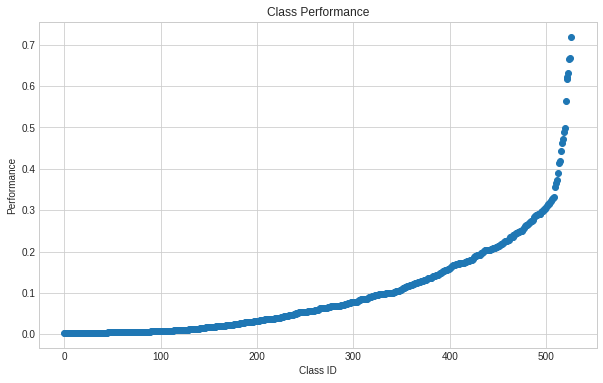

In [124]:
class_performance_np = np.array(class_perfs2)

# Sort by performance
sorted_indices = np.argsort(class_performance_np[:, 0])
sorted_data = class_performance_np[sorted_indices]

# Separate the class_ids and performances
class_ids = sorted_data[:, 1]
performances = sorted_data[:, 0]

new_index = np.arange(len(class_ids))

# Plot the data
plt.figure(figsize=(10,6))
plt.scatter(new_index, performances)
plt.title('Class Performance')
plt.ylabel('Performance')
plt.xlabel('Class ID')
plt.show()
# plt.figure(figsize=(10,6))
# plt.hexbin(new_index, performances, gridsize=50, cmap='inferno')
# plt.title('Class Performance')
# plt.ylabel('Performance')
# plt.xlabel('New Index')
# plt.colorbar(label='Density')
# plt.show()

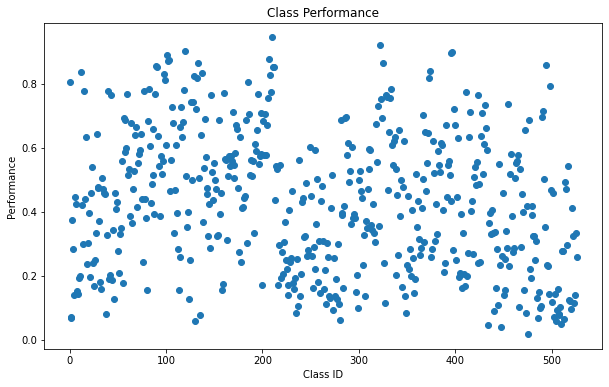

In [48]:
class_performance_np2 = np.array(class_perfs2)

# Sort by performance
sorted_indices2 = np.argsort(class_performance_np2[:, 0])
sorted_data2 = class_performance_np2[sorted_indices]

# Separate the class_ids and performances
class_ids2 = sorted_data2[:, 1]
performances2 = sorted_data2[:, 0]

# Plot the data
plt.figure(figsize=(10,6))
plt.scatter(class_ids2, performances2)
plt.title('Class Performance')
plt.ylabel('Performance')
plt.xlabel('Class ID')
plt.show()

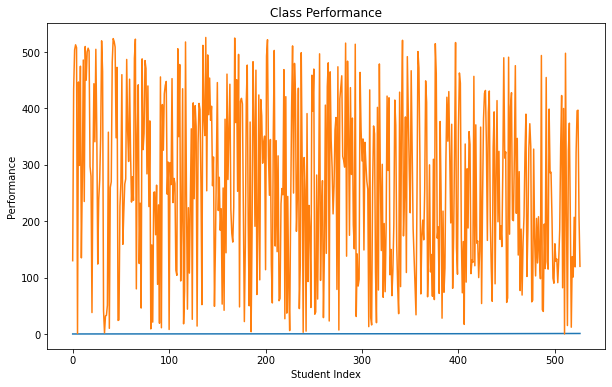

In [49]:
class_performance_np = np.array(sorted(class_perfs))
indices = np.arange(class_performance_np.shape[0])

# Plot the data
plt.figure(figsize=(10,6))
plt.plot(indices, class_performance_np)
plt.title('Class Performance')
plt.ylabel('Performance')
plt.xlabel('Student Index')
plt.show()

483


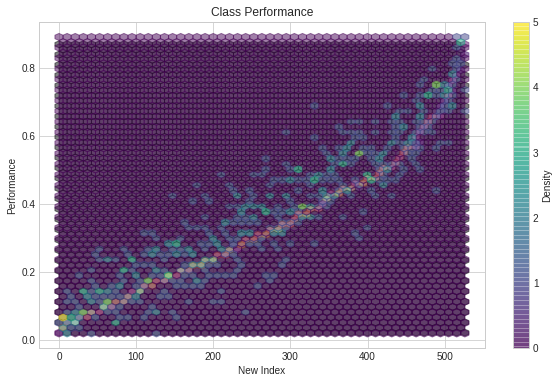

In [136]:
plt.style.use('seaborn-whitegrid')

# Assuming these are your data
class_performance = class_perfs
class_performance2 = class_perfs2

# Convert the lists to numpy arrays
class_performance_np = np.array(class_performance)
class_performance_np2 = np.array(class_performance2)
outperforms = np.sum(performances2 > performances)
print(outperforms)
# Sort by performance for the first run
sorted_indices = np.argsort(class_performance_np[:, 0])
sorted_data = class_performance_np[sorted_indices]

# Separate the class_ids and performances
class_ids = sorted_data[:, 1]
performances = sorted_data[:, 0]

# Create new index according to sorted order
new_index = np.arange(len(class_ids))

# Create a mapping from class_id to new index
class_id_to_new_index = {class_id: index for index, class_id in enumerate(class_ids)}

# Get the corresponding new indices for the second run
new_index2 = np.array([class_id_to_new_index[class_id] for class_id in class_performance_np2[:, 1]])
performances2 = class_performance_np2[:, 0]

# Plot the data as a hexbin plot
plt.figure(figsize=(10,6))

# Data from first run
plt.hexbin(new_index, performances, gridsize=50, cmap='inferno', alpha=0.5)

# Data from second run
plt.hexbin(new_index2, performances2, gridsize=50, cmap='viridis', alpha=0.5)

plt.title('Class Performance')
plt.ylabel('Performance')
plt.xlabel('New Index')
plt.colorbar(label='Density')
plt.show()

In [51]:
import statsmodels.api as sm

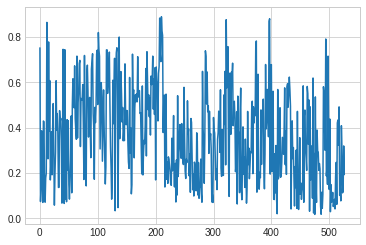

In [137]:
plt.plot(class_performance_np2[:,0])

376


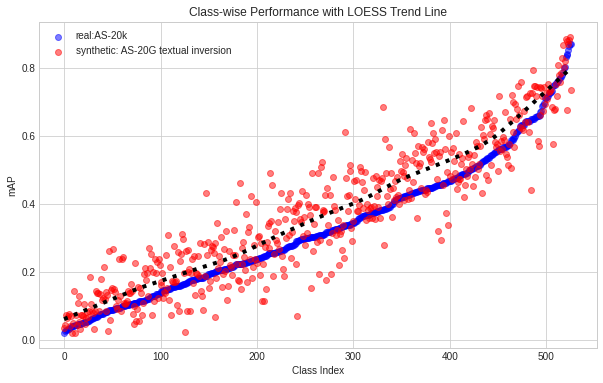

In [143]:
# Use a white background
plt.style.use('seaborn-whitegrid')
class_performance = class_perfs 
class_performance2 = class_perfs2


# Convert the lists to numpy arrays
class_performance_np = np.array(class_performance)
class_performance_np2 = np.array(class_performance2)
outperforms = np.sum(class_performance_np2  > class_performance_np)
print(outperforms)
# Sort by performance for the first run
sorted_indices = np.argsort(class_performance_np[:, 0])
sorted_data = class_performance_np[sorted_indices]

# Separate the class_ids and performances
class_ids = sorted_data[:, 1]
performances = sorted_data[:, 0]

# Create new index according to sorted order
new_index = np.arange(len(class_ids))

# Create a mapping from class_id to new index
class_id_to_new_index = {class_id: index for index, class_id in enumerate(class_ids)}

# Get the corresponding new indices for the second run
new_index2 = np.array([class_id_to_new_index[class_id] for class_id in class_performance_np2[:, 1]])
performances2 = class_performance_np2[:, 0]

# Plot the data as a scatter plot
# plt.figure(figsize=(10,6))

# Data from first run
# plt.scatter(new_index, performances, color='blue', alpha=0.5, label='real:AS-20k')

# Data from second run
# plt.scatter(new_index2, performances2, color='red', alpha=0.5, label='synthetic: AS-20G textual inversion')

# plt.title('Class-wise Performance')
# plt.ylabel('mAP')
# plt.xlabel('Class Index')
# plt.legend()
# plt.savefig('AS20kvsAS20kGT-inv.png', dpi=300)
# plt.show()

# Create an array of indices

# Fit a loess curve to the data
loess = sm.nonparametric.lowess(performances2, new_index2, frac=0.3)

# Plot the data and the loess curve
plt.figure(figsize=(10,6))
plt.scatter(new_index, performances, color='blue', alpha=0.5, label='real:AS-20k')

plt.scatter(new_index2, performances2, color='red', alpha=0.5, label='synthetic: AS-20G textual inversion')
plt.plot(loess[:, 0], loess[:, 1], color='black', linestyle='dotted', linewidth=4)
plt.title('Class-wise Performance with LOESS Trend Line')
plt.ylabel('mAP')
plt.xlabel('Class Index')
plt.legend()
plt.show()

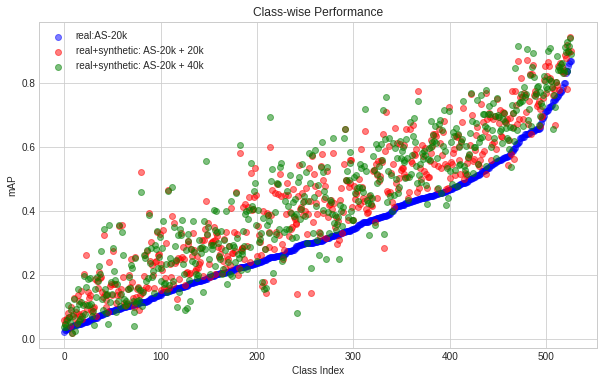

In [46]:
# Use a white background
plt.style.use('seaborn-whitegrid')

# Assuming these are your data
class_performance = class_perfs
class_performance2 = class_perfs2
class_performance3 = class_perfs3

# Convert the lists to numpy arrays
class_performance_np = np.array(class_performance)
class_performance_np2 = np.array(class_performance2)
class_performance_np3 = np.array(class_performance3)

# Sort by performance for the first run
sorted_indices = np.argsort(class_performance_np[:, 0])
sorted_data = class_performance_np[sorted_indices]

# Separate the class_ids and performances
class_ids = sorted_data[:, 1]
performances = sorted_data[:, 0]

# Create new index according to sorted order
new_index = np.arange(len(class_ids))

# Create a mapping from class_id to new index
class_id_to_new_index = {class_id: index for index, class_id in enumerate(class_ids)}

# Get the corresponding new indices for the second and third runs
new_index2 = np.array([class_id_to_new_index[class_id] for class_id in class_performance_np2[:, 1]])
performances2 = class_performance_np2[:, 0]

new_index3 = np.array([class_id_to_new_index[class_id] for class_id in class_performance_np3[:, 1]])
performances3 = class_performance_np3[:, 0]

# Plot the data as a scatter plot
plt.figure(figsize=(10,6))

# Data from first run
plt.scatter(new_index, performances, color='blue', alpha=0.5, label='real:AS-20k')

# Data from second run
plt.scatter(new_index2, performances2, color='red', alpha=0.5, label='real+synthetic: AS-20k + 20k')

# Data from third run
plt.scatter(new_index3, performances3, color='green', alpha=0.5, label='real+synthetic: AS-20k + 40k')

plt.title('Class-wise Performance')
plt.ylabel('mAP')
plt.xlabel('Class Index')
plt.legend()
plt.savefig('AS20kvsAS40kvsAS60k.png', dpi=300)
plt.show()

In [17]:
with open(os.path.join(exp_id, 'predictions', 'target.csv'), 'rb') as csv_f:
#     csv_reader = csv.DictReader(csv_f)
    lines = csv_f.readlines()
    print(lines[0])
#     print(csv_reader)
#     for row in lines:
#         print(row)

b'0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+0

In [65]:
with open(os.path.join(exp_id, 'progress.pkl'), 'rb') as f:
    progress = pickle.load(f, encoding='bytes')

epoch, global_step, best_epoch, best_mAP, time.time() - start_tim

In [66]:
[print(item) for item in progress]

[1, 5052, 1, 0.3011705580994573, 2269.9495825767517]
[2, 10104, 2, 0.3370658578190637, 4522.03178024292]
[3, 15156, 3, 0.3749324605540863, 6858.228440284729]
[4, 20208, 4, 0.3932248323546959, 9146.084376811981]


[None, None, None, None]

In [7]:
with open(os.path.join(exp_id, 'args.pkl'), 'rb') as f:
    args = pickle.load(f, encoding='bytes')

In [58]:
print(args)

Namespace(audioset_pretrain=False, bal='bal', batch_size=72, data_eval='', data_train='/local/slurm-7047405/local/audio/data/datafiles/audioset_bal_unbal_train_data.json', data_val='/local/slurm-7047405/local/audio/data/datafiles/audioset_eval_data.json', dataset='audioset_s', exp_dir='./exp/audioset_s-full-f6-t6-pTrue-b72-lr1e-5-fm12-tm60-mix0.3-m-29.686901-std40.898224-epoch10-ast_challenge', freqm=12, fstride=6, imagenet_pretrain=True, label_csv='./data/class_labels_indices.csv', lr=1e-05, lr_patience=2, mean=-29.686901, mixup=0.3, model='ast', n_class=527, n_epochs=10, n_mels=64, n_print_steps=100, num_workers=32, optim='adam', save_model=True, std=40.898224, timem=60, tstride=6)


In [19]:
log_path = "../egs/audioset/exp/"

logs = os.listdir(log_path)

filtered = [log for log in logs if ("40k" in log) or ("60k" in log) or ("80k" in log) or ("100k" in log)]

for i in range(len(filtered)):
    print(f'[{i}] - {filtered[i]}')

[0] - TALtrans-audioset_s-60k-pTrue-b448-lr1e-3-fm12-tm60-mix0.5-m-29.686901-std40.898224-epoch60-conv10-pool5-trans2-60k
[1] - TALtrans-audioset_s-60kc-pTrue-b448-lr1e-3-fm0-tm0-mix0-m-29.686901-std40.898224-epoch60-conv10-pool5-trans2-60kc-1
[2] - TALtrans-audioset_s-60k-pTrue-b448-lr5e-5-fm12-tm60-mix0.3-m-29.686901-std40.898224-epoch25-conv10-pool5-trans2-60k-1-2
[3] - TALtrans-audioset_s-60k-pTrue-b448-lr1e-4-fm12-tm60-mix0.3-m-29.686901-std40.898224-epoch25-conv10-pool5-trans2-60k-2
[4] - TALtrans-audioset_s-60k-pTrue-b448-lr1e-3-fm0-tm0-mix0-m-29.686901-std40.898224-epoch60-conv10-pool5-trans2-60k-1
[5] - TALtrans-audioset_s-80k-pTrue-b448-lr1e-3-fm0-tm0-mix0-m-29.686901-std40.898224-epoch60-conv10-pool5-trans2-80k-1
[6] - TALtrans-audioset_s-60kc-pTrue-b448-lr1e-3-fm0-tm0-mix0-m-29.686901-std40.898224-epoch60-conv10-pool5-trans2-60kc-3
[7] - TALtrans-audioset_s-40k-pTrue-b448-lr1e-3-fm0-tm0-mix0-m-29.686901-std40.898224-epoch60-conv10-pool5-trans2-40k
[8] - TALtrans-audioset_s-

In [20]:

def get_acc(idx, names, folder):
    targ = names[idx]

    df = pd.read_csv(os.path.join(log_path, targ, 'result.csv'), header=None)
    # print(df)
#     plt.plot(df[0])
#     plt.show()
    return df[0]
    
get_all = [0,1,2,3,4,5,6,7,8,9,10]
    
chosen = [1, 9]

accs = [get_acc(num, filtered, log_path) for num in chosen]

for log in accs:
    plt.plot(log)
    
plt.show()
    

FileNotFoundError: [Errno 2] No such file or directory: '../egs/audioset/exp/TALtrans-audioset_s-60kc-pTrue-b448-lr1e-3-fm0-tm0-mix0-m-29.686901-std40.898224-epoch60-conv10-pool5-trans2-60kc-1/result.csv'